# Part 1: Dataset optimization for training on the Cloud

### Why is training on the Cloud different?
1. Files are remote, which requires downloading (slow)
2. Cloud services have rate-limits on how many files can be downloaded per second (~1.5k / sec / file prefix)
3. Very large dataset's might not fit on disk

### What can we do about it?
We want to minimize the number of file transfers.
To do that we need to store the data in a format that's optimized
1. Storing the data compressed
2. Group files

This would reduce:
* the amount of files required to be downloaded
* time to download the data
* risk of rate-limiting
* amount of data needed in memory per batch

In [1]:
s3_path = "/teamspace/s3_connections/computer-vision-example"

The ImageNet 1M dataset contains 1,431,167 labeled images according to the WordNet hierarchy and has been used a reference dataset for compute vision for many years.

Total number of images:
* Train: 1,281,167
* Validation: 50,000
* Test: 100,000

In [3]:
! git clone https://github.com/Lightning-AI/lightning.git


Cloning into 'lightning'...
remote: Enumerating objects: 138947, done.        
remote: Counting objects: 100% (11972/11972), done.        
remote: Compressing objects: 100% (1519/1519), done.        
remote: Total 138947 (delta 11265), reused 10628 (delta 10450), pack-reused 126975        
Receiving objects: 100% (138947/138947), 125.65 MiB | 32.16 MiB/s, done.
Resolving deltas: 100% (111765/111765), done.

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/6d/13/b5e8bacd980b2195f8a1741ce11cbb9146568607795d5e4ff510dcff1064/torch-2.1.0-cp310-cp310-manylinux1_x86_64.whl.metadata
  Using cached torch-2.1.0-cp310-cp310-manylinux1_x86_64.whl.metadata (25 kB)
  Obtaining dependency information for lightning-cloud from https://files.pythonhosted.org/packages/b4/7a/c88ae108a5abdac5ae9bc39005cab90ca1e341d9046f4862a70c87166a49/lightning_cloud-0.5.44-py3-none-any.whl.metadata
  Using cached lightning_cloud-0.5.44-py3-none-any.whl.metadata (933 bytes)
  Obtai

In [2]:
!!cd lightning && git checkout fd48627303386a342e5252098ad7fb0d48a14cb8 && pip install -e .
! pip install -U torch lightning-cloud matplotlib torchvision


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


## Optimize the ImageNet dataset for training
with `DatasetOptimizer` and `StreamingDataset`

In [3]:
from lightning import LightningDataModule
from lightning.data import StreamingDataset, StreamingDataLoader, DatasetOptimizer
import torchvision.transforms as T
from PIL import Image
from tqdm.auto import tqdm
from imagenet_utils import get_class_index_from_filepath, to_rgb, shuffle, load_imagenet_val_class_names, class_names_to_index_map
from lightning.data.streaming.dataset import StreamingDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 35363  100 35363    0     0   585k      0 --:--:-- --:--:-- --:--:--  585k


In [4]:
class ImageNetStreamingDataset(StreamingDataset):

    def __init__(self, name, version):
        super().__init__(name=name, version=version)
        self.transform = T.Compose([
            T.RandomResizedCrop((224, 224), antialias=True),
        ])

    def __getitem__(self, index):
        # Note: If torchvision is installed, we return a tensor image instead of a pil image as it is much faster. 
        img, class_index = super().__getitem__(index) # <- Whatever you returned from the DatasetOptimizer prepare_item method.
        return self.transform(to_rgb(img) / 255.), int(class_index)   


class ImageNetCloudDataModule(LightningDataModule):

    @staticmethod
    def prepare_dataset_structure(root, image_paths):
        if "train" in root:
            class_indexes = [get_class_index_from_filepath(image_path) for image_path in image_paths]
            items_metadata = [(image_path, class_index) for image_path, class_index in zip(image_paths, class_indexes)]
            return shuffle(items_metadata)
        else:
            class_names = load_imagenet_val_class_names()
            return [(image_path, class_names_to_index_map[class_name]) for image_path, class_name in zip(image_paths, class_names)]
            
    @staticmethod
    def prepare_item(item_metadata):
        image_path, class_index = item_metadata
        return [Image.open(image_path), class_index] # <- What you return here is what you get in the StreamingDataset
    
    @property
    def train_dataset(self):
        return ImageNetStreamingDataset(name="imagenet/train", version="latest")

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=256, num_workers=os.cpu_count(), pin_memory=True)

    @property
    def val_dataset(self):
        return ImageNetStreamingDataset(name="imagenet/val", version="latest")
        
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=256, num_workers=os.cpu_count(), pin_memory=True)


data_module = ImageNetCloudDataModule()

### Verify before processing the entire dataset
We run the `DatasetOptimizer` in `fast_dev_run=True` mode to verify everything works fine.

Listing files the first time is slow but it get cached. It should take roughtly 5 min.

In [5]:
!!sudo rm -r /cache/data /cache/imagenet
! rm -rf ~/.cache/imagenet

In [6]:
dataset_optimizer = DatasetOptimizer(
    name="imagenet/train",
    src_dir=f"{s3_path}/train",
    fast_dev_run=True,
    num_workers=4,
)
dataset_optimizer.run(data_module)

Storing the files under s3://grid-cloud-litng-ai-03/projects/01h5rame86jsrn91rnywfd7bjy/optimized_datasets/imagenet/train/version_43
Setup started for `imagenet/train` with fast_dev_run=True.


Seed set to 42


here
/teamspace/s3_connections/computer-vision-example/train/Afghan_hound/n02088094_10.JPEG
/teamspace/s3_connections/computer-vision-example/train/Afghan_hound/n02088094_1003.JPEG
/teamspace/s3_connections/computer-vision-example/train/Afghan_hound/n02088094_1006.JPEG
/teamspace/s3_connections/computer-vision-example/train/Afghan_hound/n02088094_1007.JPEG
/teamspace/s3_connections/computer-vision-example/train/Afghan_hound/n02088094_10078.JPEG
/teamspace/s3_connections/computer-vision-example/train/Afghan_hound/n02088094_1008.JPEG
/teamspace/s3_connections/computer-vision-example/train/Afghan_hound/n02088094_10082.JPEG
/teamspace/s3_connections/computer-vision-example/train/Afghan_hound/n02088094_10087.JPEG
/teamspace/s3_connections/computer-vision-example/train/Afghan_hound/n02088094_10089.JPEG
/teamspace/s3_connections/computer-vision-example/train/Afghan_hound/n02088094_10095.JPEG
/teamspace/s3_connections/computer-vision-example/train/Afghan_hound/n02088094_10096.JPEG
/teamspace/s

  0%|          | 0/40 [00:00<?, ?it/s]

Worker 1 is done.
Worker 2 is done.
Worker 0 is done.
Worker 3 is done.
Workers are finished.
Finished data processing!


In [13]:
dataset_optimizer = DatasetOptimizer(
    name="imagenet/val",
    src_dir=f"{s3_path}/val",
    fast_dev_run=True,
    num_workers=4,
)
dataset_optimizer.run(data_module)

Storing the files under s3://grid-cloud-litng-ai-03/projects/01h5rame86jsrn91rnywfd7bjy/optimized_datasets/imagenet/val/version_19
Setup started for `imagenet/val` with fast_dev_run=True.


Seed set to 42


Setup finished in 5.633 seconds. Found 50000 items to process.
Fast dev run is enabled. Limiting to 10 items per process.
Starting 4 workers


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  488k  100  488k    0     0  4787k      0 --:--:-- --:--:-- --:--:-- 4834k


Workers are ready ! Starting data processing...


  0%|          | 0/40 [00:00<?, ?it/s]

Worker 2 is done.
Worker 1 is done.
Worker 3 is done.
Worker 0 is done.
Workers are finished.
Finished data processing!


Number of samples: 40
First element: (tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.

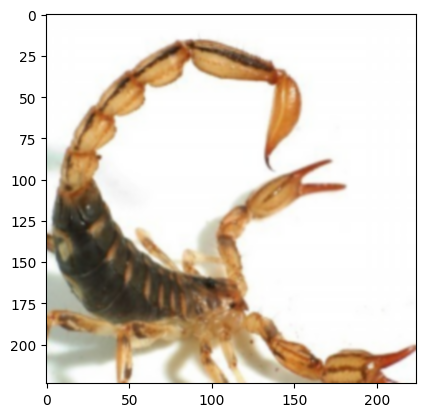

In [6]:
from lightning.data.streaming.dataset import StreamingDataset

train_dataset = data_module.train_dataset

print(f"Number of samples: {len(train_dataset)}")
print(f"First element: {train_dataset[0]}")

image, target = train_dataset[0]
plt.imshow(T.ToPILImage()(image), interpolation="bicubic")
plt.show()

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
import torch 
from torchmetrics import Accuracy
import torch.nn.functional as F
from torch import inference_mode
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)
model.eval()
acc_metric = Accuracy(task="multiclass", num_classes=1000, top_k=5).to(device)

dataloader = data_module.train_dataloader()

with inference_mode():
    for batch in tqdm(dataloader, smoothing=0):
        images, target = batch
        images = images.to(device).float()
        target = target.to(device)
        output = model(images)
        acc = acc_metric(output, target)
    print(f"The model accuracy is {acc_metric.compute() * 100} %.")

### Great, everything works! Let's optimize the entire dataset (this can take up to an hour):

 Remember to clear your cache before creating your new dataset

In [ ]:
!!sudo rm -r /cache/data /cache/imagenet

In [ ]:
dataset_optimizer = DatasetOptimizer(
    name="imagenet/train",
    src_dir=f"{s3_path}/train",
    fast_dev_run=False,
    num_workers=32,
)
dataset_optimizer.run(recipe)

In [ ]:
dataset_optimizer = DatasetOptimizer(
    name="imagenet/val",
    src_dir=f"{s3_path}/val",
    fast_dev_run=False,
    num_workers=32,
)
dataset_optimizer.run(recipe)

# Part 2: Multi-GPU on the Cloud

## How can multiple GPU's help?
Training on the Cloud is expensive. The faster we can train the cheaper it is for us and the more development iterations we can get through in a shorter period of time.

- Distributed Data Parallel (DDP) allows to  process batches  in parallel
- (Cost of 4xT4) < 4 * (Cost of 1xT4)
    - A 4x speed up without paying 4x the price

## 

In [17]:
from typing import Optional
import os
import torch
import torch.nn.functional as F
import torch.optim as optim
from lightning.pytorch import LightningModule, Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, TQDMProgressBar
from lightning.pytorch.utilities.model_helpers import get_torchvision_model
from imagenet_utils import (
    get_class_index_from_filepath,
    to_rgb,
    shuffle,
    load_imagenet_val_class_names,
    class_names_to_index_map,
)
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy
from lightning import LightningDataModule
from lightning.data import StreamingDataset
import torchvision.transforms as T


In [ ]:

class ImageNetLightningModel(LightningModule):

    def __init__(
        self,
        arch: str = "resnet18",
        weights: Optional[str] = None,
        lr: float = 0.1,
        momentum: float = 0.9,
        weight_decay: float = 1e-4,
        batch_size: int = 256,
        workers: int = 4,
    ):
        super().__init__()
        self.arch = arch
        self.weights = weights
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.workers = workers
        self.model = get_torchvision_model(self.arch, weights=self.weights)
        self.train_acc1 = Accuracy(task="multiclass", num_classes=1000, top_k=1)
        self.eval_acc1 = Accuracy(task="multiclass", num_classes=1000, top_k=1)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, target = batch
        output = self.model(images)
        loss_train = F.cross_entropy(output, target)
        self.log("train_loss", loss_train)
        # update metrics
        self.train_acc1(output, target)
        self.log("train_acc1", self.train_acc1, prog_bar=True)
        return loss_train

    def eval_step(self, batch, batch_idx, prefix: str):
        images, target = batch
        output = self.model(images)
        loss_val = F.cross_entropy(output, target)
        self.log(f"{prefix}_loss", loss_val)
        # update metrics
        self.eval_acc1(output, target)
        self.log(f"{prefix}_acc1", self.eval_acc1, prog_bar=True)
        return loss_val

    def validation_step(self, batch, batch_idx):
        return self.eval_step(batch, batch_idx, "val")

    # def test_step(self, batch, batch_idx):
        return self.eval_step(batch, batch_idx, "test")

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.1 ** (epoch // 30))
        return [optimizer], [scheduler]



### Let's train

In [ ]:

model = ImageNetLightningModel()
data_module = ImageNetCloudDataModule()
trainer = Trainer(
    max_epochs=90,
    accelerator="auto",
    devices="auto",
    logger=False,
    callbacks=[
        TQDMProgressBar(refresh_rate=10),
        ModelCheckpoint(monitor="val_acc1", mode="max"),
    ],
)
trainer.fit(model, data_module)